## 1. Imports

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    Normalizer,
    OneHotEncoder
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold
)

from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.ensemble import (
    RandomForestClassifier
)

from sklearn.neural_network import MLPClassifier

import warnings

In [2]:
warnings.filterwarnings('ignore')

## 2. Dataset

In [3]:
df = pd.read_csv("./data/star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### 2.1. Resumo

Os dados consistem em 100.000 observações do espaço obtidas pelo SDSS (Sloan Digital Sky Survey). Cada observação é descrita por 17 colunas de características e 1 coluna de classe que a identifica como uma estrela, galáxia ou quasar.

obj_ID = Object Identifier, valor único que identifica o objeto no catálogo de imagens utilizado pelo CAS

alfa = Ângulo de ascensão reta (na época J2000)

delta = Ângulo de declinação (na época J2000)

u = Filtro ultravioleta no sistema fotométrico

g = Filtro verde no sistema fotométrico

r = Filtro vermelho no sistema fotométrico

i = Filtro infravermelho próximo no sistema fotométrico

z = Filtro infravermelho no sistema fotométrico

run_ID = Número de execução usado para identificar a verificação específica

rereun_ID = Número de nova execução para especificar como a imagem foi processada

cam_col = Coluna da câmera para identificar a linha de varredura na execução

field_ID = Número do campo para identificar cada campo

spec_obj_ID = ID exclusivo usado para objetos espectroscópicos ópticos (isso significa que 2 observações diferentes com o mesmo spec_obj_ID devem compartilhar a classe de saída)

class = classe do objeto (objeto galáxia, estrela ou quasar)

redshift = valor do redshift com base no aumento do comprimento de onda

plate = ID do plate, identifica cada plate no SDSS

MJD = Data Juliana Modificada, usada para indicar quando um determinado dado do SDSS foi obtido

Fiber_ID = ID da fibra que identifica a fibra que apontou a luz para o plano focal em cada observação

## 3. Limpeza e Tratamento

### 3.2. Remoção de Erros

In [4]:
df = df[df["u"] != -9999]

### 3.3. Resumo dos Dados

In [5]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.237665e+18,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,4481.403354,301.0,3.511625,186.127011,5.783903e+18,0.576667,5137.027890,55588.653687,449.315613
std,8.438450e+12,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1964.739021,0.0,1.586913,149.007687,3.324026e+18,0.730709,2952.312485,1808.492217,272.498252
min,1.237646e+18,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,3187.000000,301.0,2.000000,82.000000,2.844137e+18,0.054522,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4188.000000,301.0,4.000000,146.000000,5.614896e+18,0.424176,4987.000000,55869.000000,433.000000
75%,1.237668e+18,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5326.000000,301.0,5.000000,241.000000,8.332365e+18,0.704172,7400.500000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [6]:
df.nunique()

obj_ID         78052
alpha          99998
delta          99998
u              93747
g              92650
r              91900
i              92018
z              92006
run_ID           430
rerun_ID           1
cam_col            6
field_ID         856
spec_obj_ID    99999
class              3
redshift       99294
plate           6284
MJD             2180
fiber_ID        1000
dtype: int64

In [7]:
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

## 4. Análise Exploratória de Dados

### 4.1. Correlação com Classes

In [8]:
df_aed = df.copy()

In [9]:
cols_rem = ["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "fiber_ID", "MJD"]

In [10]:
df_aed.drop(cols_rem, axis=1, inplace=True)

In [11]:
ohe = OneHotEncoder()

In [13]:
values_enc = ohe.fit_transform(df_aed["class"].values.reshape(-1, 1)).toarray()

cols_class = ohe.categories_[0]

In [17]:
df_aed[cols_class] = values_enc

In [19]:
df_corr = df_aed.drop("class", axis=1).corr().abs()

In [20]:
df_corr_class = pd.concat(
    [
        df_corr["GALAXY"],
        df_corr["STAR"],
        df_corr["QSO"]
    ], axis=1
).drop(index=["GALAXY", "QSO", "STAR"], axis=0).round(2)

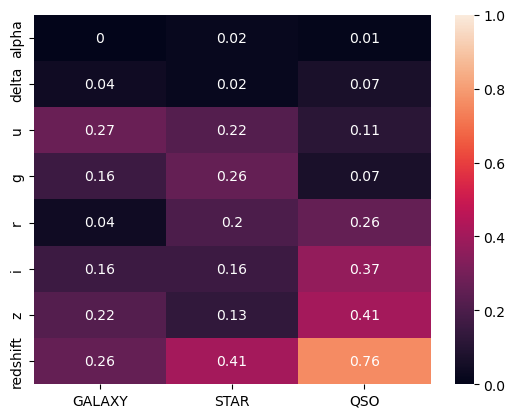

In [21]:
sns.heatmap(df_corr_class, vmax=1, vmin=0, annot=True)

plt.show()

### 4.2. Correlação entre Variáveis

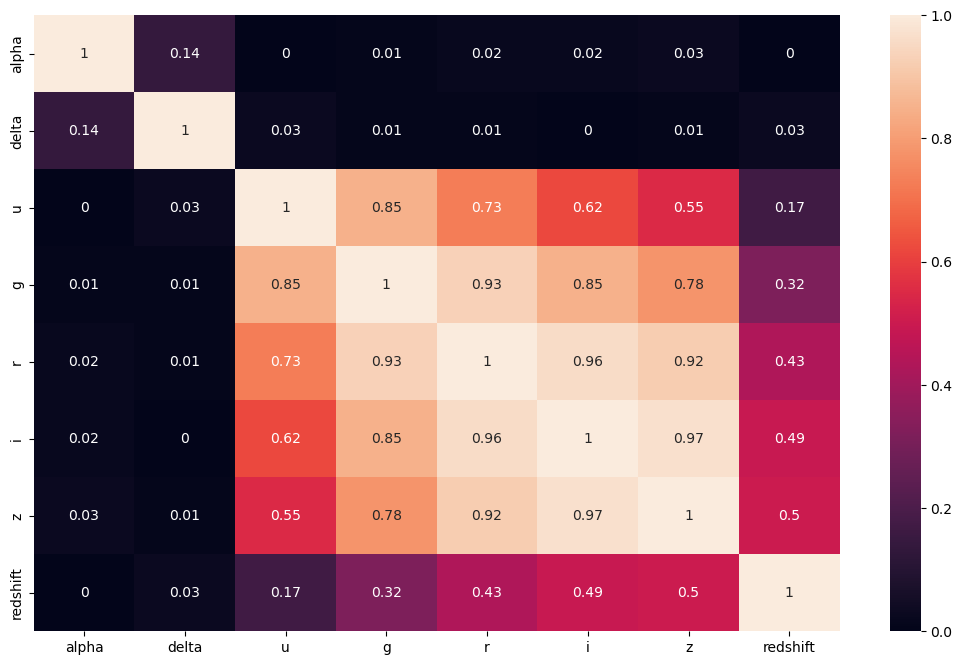

In [95]:
plt.figure(figsize=(13, 8))

sns.heatmap(
    df_aed.drop(["class", "GALAXY", "QSO", "STAR"], axis=1).corr().abs().round(2),
    vmin=0, vmax=1, annot=True
)

plt.show()

### 4.3. Distribuição das Variáveis

#### 4.3.1. Análise Univariada

##### 4.3.1.1. KDE

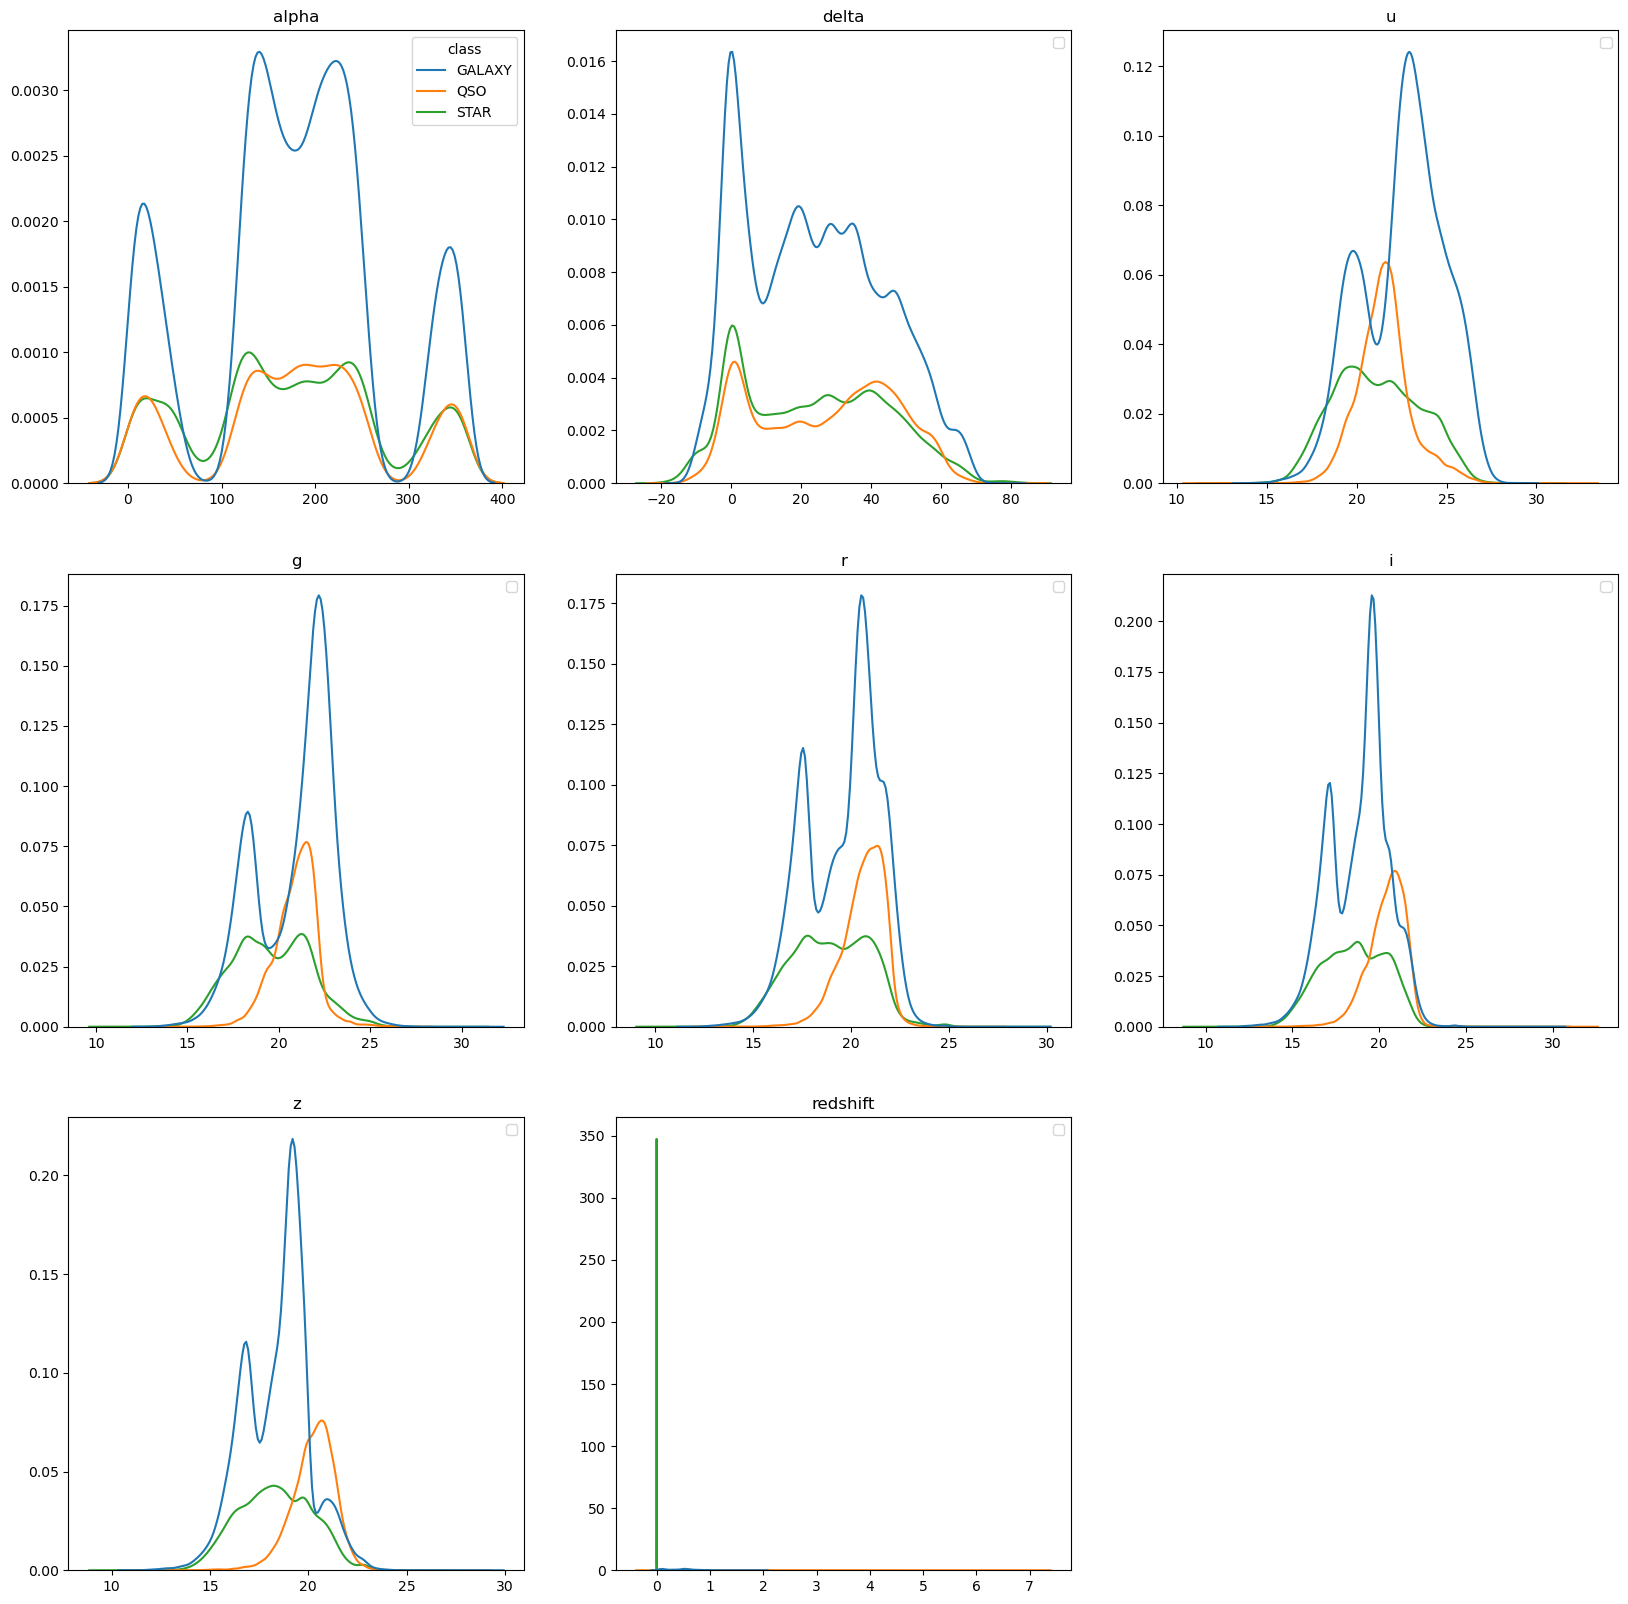

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

cols = df_aed.drop(["class", "GALAXY", "QSO", "STAR"], axis=1).columns

for i, col in enumerate(cols):
    
    k = i // 3
    j = i % 3

    sns.kdeplot(data=df_aed, x=col, hue="class", ax=axs[k, j])

    if k + j:
        axs[k, j].legend("")

    axs[k, j].set_title(col)
    axs[k, j].set_ylabel("")
    axs[k, j].set_xlabel("")

fig.delaxes(axs[2][2])

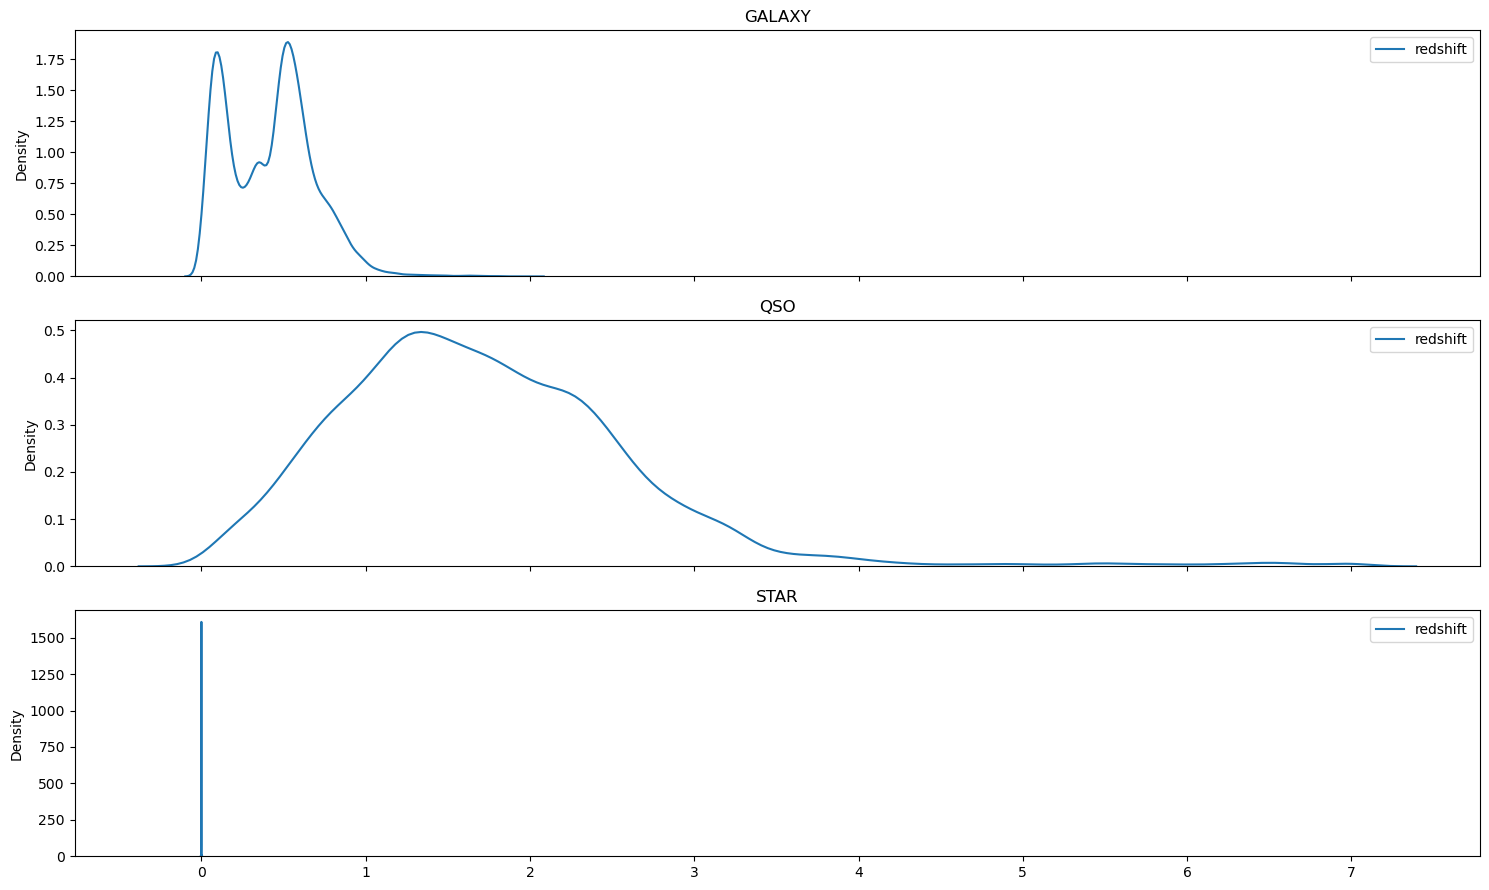

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 9))

# Plotar nos subplots individuais
sns.kdeplot(data=df_aed[["redshift", "class"]].query('`class` == "GALAXY"'), ax=ax1)
sns.kdeplot(data=df_aed[["redshift", "class"]].query('`class` == "QSO"'), ax=ax2)
sns.kdeplot(data=df_aed[["redshift", "class"]].query('`class` == "STAR"'), ax=ax3)

ax1.set_title("GALAXY")
ax2.set_title("QSO")
ax3.set_title("STAR")


# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

##### 4.3.1.2. Box

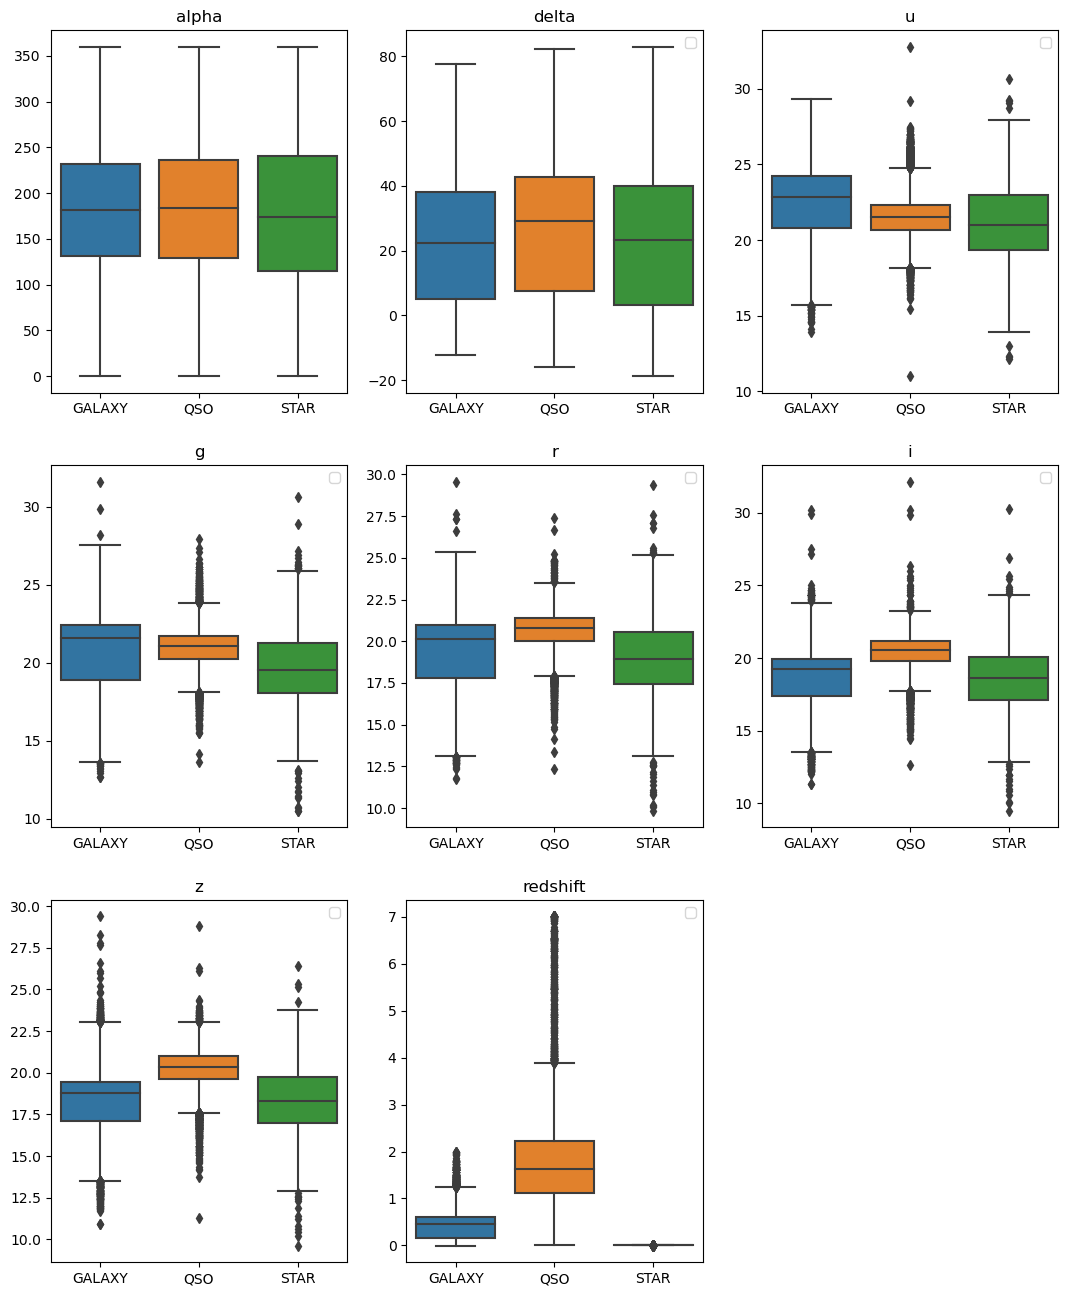

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(13, 16))

cols = df_aed.drop(["class", "GALAXY", "QSO", "STAR"], axis=1).columns

for i, col in enumerate(cols):
    
    k = i // 3
    j = i % 3

    sns.boxplot(data=df_aed, y=col, x="class", ax=axs[k, j])

    if k + j:
        axs[k, j].legend("")

    axs[k, j].set_title(col)
    axs[k, j].set_ylabel("")
    axs[k, j].set_xlabel("")

fig.delaxes(axs[2][2])

#### 4.3.2. Análise Multivariada

##### 4.3.2.1. Scatter

In [47]:
df_aed.columns

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift',
       'GALAXY', 'QSO', 'STAR'],
      dtype='object')

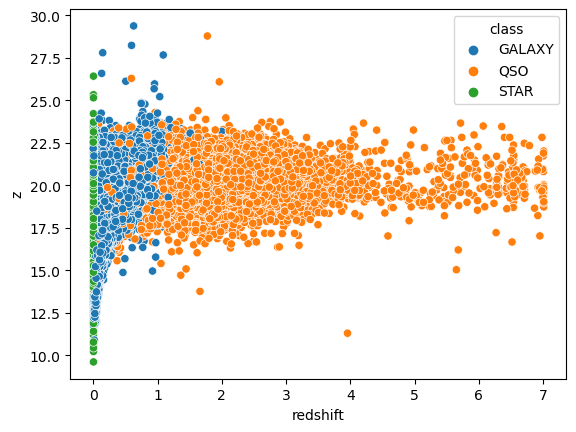

In [48]:
# good combinations
# x, y = "redshift", "z"

x = "redshift"
y = "z"

sns.scatterplot(data=df_aed, x=x, y=y, hue="class")

plt.show()

## 5. Modelagem

In [84]:
seed = 94

### 5.1. Geração de diferentes subconjuntos de variáveis

In [89]:
# colunas com baixa correlação entre si

cols_corr_bet_01 = ["alpha", "delta", "u", "i", "redshift", "class"]

cols_corr_bet_02 = ["alpha", "delta", "u", "z", "redshift", "class"]

In [90]:
# precisamos embasar melhor a escolha desses subconjuntos

cols_teste_01 = ["alpha", "delta", "u", "r", "g", "i", "z", "redshift", "class"]

cols_teste_02 = ["redshift", "class"]

In [25]:
cols_01 = list((set(cols_teste_01) & set(cols_corr_bet_01)))
cols_02 = list((set(cols_teste_01) & set(cols_corr_bet_02)))
cols_03 = list(set(cols_corr_bet_01))
cols_04 = list(set(cols_corr_bet_02))
cols_05 = list(set(cols_teste_01))
cols_06 = list(set(cols_teste_02))

In [26]:
df_00 = df
df_01 = df[cols_01]
df_02 = df[cols_02]
df_03 = df[cols_03]
df_04 = df[cols_04]
df_05 = df[cols_05]
df_06 = df[cols_06]

### 5.2. Divisão em Treino e Teste

In [27]:
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [28]:
def get_prepared_data(df: pd.DataFrame) -> pd.DataFrame:
    x, y = df.drop("class", axis=1), df["class"]
    
    cols = list(x.columns)
    
    x = st_scaler.fit_transform(x)
    x = mm_scaler.fit_transform(x)

    df = pd.DataFrame(x, columns=cols)

    df["class"] = y

    return df

In [29]:
df_00 = get_prepared_data(df_00)
df_01 = get_prepared_data(df_01)
df_02 = get_prepared_data(df_02)
df_03 = get_prepared_data(df_03)
df_04 = get_prepared_data(df_04)
df_05 = get_prepared_data(df_05)
df_06 = get_prepared_data(df_06)

In [30]:
X_00, y = df_00.drop("class", axis=1), df["class"]
X_01, y = df_01.drop("class", axis=1), df["class"]
X_02, y = df_02.drop("class", axis=1), df["class"]
X_03, y = df_03.drop("class", axis=1), df["class"]
X_04, y = df_04.drop("class", axis=1), df["class"]
X_05, y = df_05.drop("class", axis=1), df["class"]
X_06, y = df_06.drop("class", axis=1), df["class"]

In [31]:
X_training_00, X_test_00, y_training, y_test = train_test_split(X_00, y, random_state=seed, test_size=0.25, stratify=y)
X_training_01, X_test_01, y_training, y_test = train_test_split(X_01, y, random_state=seed, test_size=0.25, stratify=y)
X_training_02, X_test_02, y_training, y_test = train_test_split(X_02, y, random_state=seed, test_size=0.25, stratify=y)
X_training_03, X_test_03, y_training, y_test = train_test_split(X_03, y, random_state=seed, test_size=0.25, stratify=y)
X_training_04, X_test_04, y_training, y_test = train_test_split(X_04, y, random_state=seed, test_size=0.25, stratify=y)
X_training_05, X_test_05, y_training, y_test = train_test_split(X_05, y, random_state=seed, test_size=0.25, stratify=y)
X_training_06, X_test_06, y_training, y_test = train_test_split(X_06, y, random_state=seed, test_size=0.25, stratify=y)

In [32]:
X_train_00, X_val_00, y_train, y_val = train_test_split(X_training_00, y_training, random_state=seed, test_size=0.33, stratify=y_training)
X_train_01, X_val_01, y_train, y_val = train_test_split(X_training_01, y_training, random_state=seed, test_size=0.33, stratify=y_training)
X_train_02, X_val_02, y_train, y_val = train_test_split(X_training_02, y_training, random_state=seed, test_size=0.33, stratify=y_training)
X_train_03, X_val_03, y_train, y_val = train_test_split(X_training_03, y_training, random_state=seed, test_size=0.33, stratify=y_training)
X_train_04, X_val_04, y_train, y_val = train_test_split(X_training_04, y_training, random_state=seed, test_size=0.33, stratify=y_training)
X_train_05, X_val_05, y_train, y_val = train_test_split(X_training_05, y_training, random_state=seed, test_size=0.33, stratify=y_training)
X_train_06, X_val_06, y_train, y_val = train_test_split(X_training_06, y_training, random_state=seed, test_size=0.33, stratify=y_training)

### 5.3. Classificação

In [33]:
kfolder = StratifiedKFold(10, random_state=seed, shuffle=True)

In [41]:
def get_results_model(x_train, y_train, x_val, y_val, model, params):

    x_training = pd.concat([
        x_train,
        x_val
    ], axis=0)

    y_training = pd.concat([
        y_train,
        y_val
    ], axis=0)
    
    scores_cv = cross_val_score(model(**params), x_training, y_training, cv=kfolder)

    for i, score in enumerate(scores_cv):
        print(f"[FOLD {i}] SCORE = {round(score, 5)}")

    print(f"Acurácia média dos k-folds:.......{scores_cv.mean()}")

    cls = model(**params)

    cls.fit(x_train.values, y_train.values)

    y_pred = cls.predict(x_val.values)

    cm = confusion_matrix(y_val, y_pred)
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=cls.classes_
    )

    print("Acurácia no conjunto de treino:... {:.3f}".format(cls.score(x_train.values, y_train.values)))
    print("Acurácia no conjunto de validação: {:.3f}".format(cls.score(x_val.values, y_val.values)))
    print(classification_report(y_val.values, y_pred))

    disp.plot(cmap='Blues')

    plt.show()

#### 5.3.1. Rede Neural

##### 5.3.1.1. Teste com todas as variáveis

In [54]:
parameters = {
    'activation': 'relu', 
    'solver': 'sgd', 
    'hidden_layer_sizes': (10, ), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.9448
[FOLD 1] SCORE = 0.94333
[FOLD 2] SCORE = 0.9436
[FOLD 3] SCORE = 0.94667
[FOLD 4] SCORE = 0.94387
[FOLD 5] SCORE = 0.94827
[FOLD 6] SCORE = 0.94253
[FOLD 7] SCORE = 0.9424
[FOLD 8] SCORE = 0.94853
[FOLD 9] SCORE = 0.94413
Acurácia média dos k-folds:.......0.9448125883451126
Acurácia no conjunto de treino:... 0.937
Acurácia no conjunto de validação: 0.937
              precision    recall  f1-score   support

      GALAXY       0.94      0.96      0.95     14713
         QSO       0.95      0.87      0.91      4693
        STAR       0.92      0.94      0.93      5344

    accuracy                           0.94     24750
   macro avg       0.94      0.92      0.93     24750
weighted avg       0.94      0.94      0.94     24750



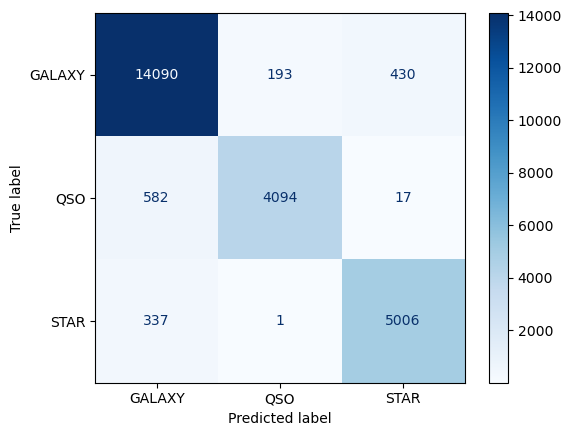

In [43]:
get_results_model(X_train_00, y_train, X_val_00, y_val, MLPClassifier, parameters)

##### 5.3.1.2. Teste com conjunto nº 1

[FOLD 0] SCORE = 0.94773
[FOLD 1] SCORE = 0.9424
[FOLD 2] SCORE = 0.9424
[FOLD 3] SCORE = 0.94653
[FOLD 4] SCORE = 0.9432
[FOLD 5] SCORE = 0.948
[FOLD 6] SCORE = 0.94293
[FOLD 7] SCORE = 0.93853
[FOLD 8] SCORE = 0.94667
[FOLD 9] SCORE = 0.94093
Acurácia média dos k-folds:.......0.9439325456727564
Acurácia no conjunto de treino:... 0.937
Acurácia no conjunto de validação: 0.936
              precision    recall  f1-score   support

      GALAXY       0.94      0.95      0.95     14713
         QSO       0.95      0.86      0.90      4693
        STAR       0.92      0.95      0.93      5344

    accuracy                           0.94     24750
   macro avg       0.93      0.92      0.93     24750
weighted avg       0.94      0.94      0.94     24750



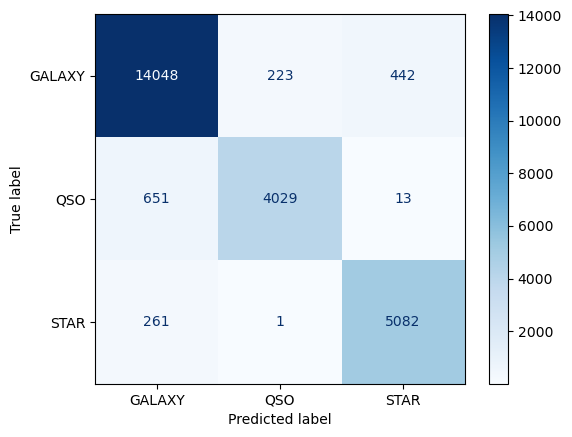

In [47]:
get_results_model(X_train_01, y_train, X_val_01, y_val, MLPClassifier, parameters)

##### 5.3.1.3. Teste com conjunto nº 2

[FOLD 0] SCORE = 0.94587
[FOLD 1] SCORE = 0.9388
[FOLD 2] SCORE = 0.93853
[FOLD 3] SCORE = 0.94253
[FOLD 4] SCORE = 0.93853
[FOLD 5] SCORE = 0.942
[FOLD 6] SCORE = 0.9404
[FOLD 7] SCORE = 0.93667
[FOLD 8] SCORE = 0.94107
[FOLD 9] SCORE = 0.93679
Acurácia média dos k-folds:.......0.9401191572209628
Acurácia no conjunto de treino:... 0.934
Acurácia no conjunto de validação: 0.933
              precision    recall  f1-score   support

      GALAXY       0.94      0.95      0.94     14713
         QSO       0.94      0.86      0.90      4693
        STAR       0.92      0.94      0.93      5344

    accuracy                           0.93     24750
   macro avg       0.93      0.92      0.92     24750
weighted avg       0.93      0.93      0.93     24750



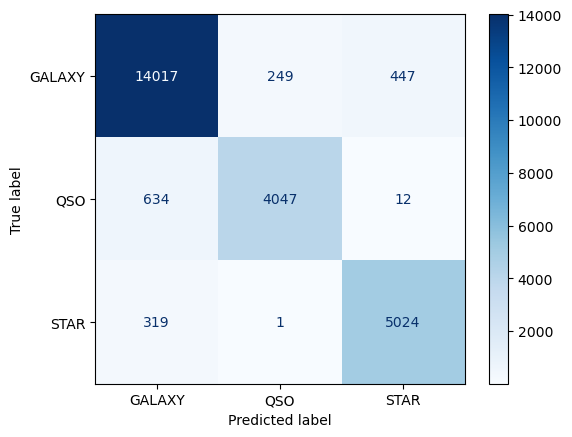

In [48]:
get_results_model(X_train_02, y_train, X_val_02, y_val, MLPClassifier, parameters)

##### 5.3.1.4. Teste com conjunto nº 3

[FOLD 0] SCORE = 0.94773
[FOLD 1] SCORE = 0.9424
[FOLD 2] SCORE = 0.9424
[FOLD 3] SCORE = 0.94653
[FOLD 4] SCORE = 0.9432
[FOLD 5] SCORE = 0.948
[FOLD 6] SCORE = 0.94293
[FOLD 7] SCORE = 0.93853
[FOLD 8] SCORE = 0.94667
[FOLD 9] SCORE = 0.94093
Acurácia média dos k-folds:.......0.9439325456727564
Acurácia no conjunto de treino:... 0.937
Acurácia no conjunto de validação: 0.936
              precision    recall  f1-score   support

      GALAXY       0.94      0.95      0.95     14713
         QSO       0.95      0.86      0.90      4693
        STAR       0.92      0.95      0.93      5344

    accuracy                           0.94     24750
   macro avg       0.93      0.92      0.93     24750
weighted avg       0.94      0.94      0.94     24750



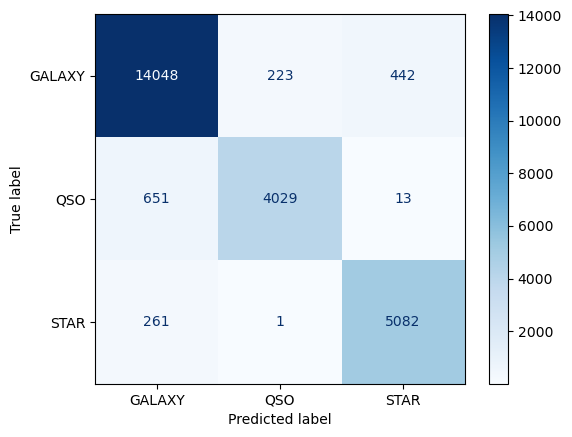

In [49]:
get_results_model(X_train_03, y_train, X_val_03, y_val, MLPClassifier, parameters)

##### 5.3.1.5. Teste com conjunto nº 4

[FOLD 0] SCORE = 0.94587
[FOLD 1] SCORE = 0.9388
[FOLD 2] SCORE = 0.93853
[FOLD 3] SCORE = 0.94253
[FOLD 4] SCORE = 0.93853
[FOLD 5] SCORE = 0.942
[FOLD 6] SCORE = 0.9404
[FOLD 7] SCORE = 0.93667
[FOLD 8] SCORE = 0.94107
[FOLD 9] SCORE = 0.93679
Acurácia média dos k-folds:.......0.9401191572209628
Acurácia no conjunto de treino:... 0.934
Acurácia no conjunto de validação: 0.933
              precision    recall  f1-score   support

      GALAXY       0.94      0.95      0.94     14713
         QSO       0.94      0.86      0.90      4693
        STAR       0.92      0.94      0.93      5344

    accuracy                           0.93     24750
   macro avg       0.93      0.92      0.92     24750
weighted avg       0.93      0.93      0.93     24750



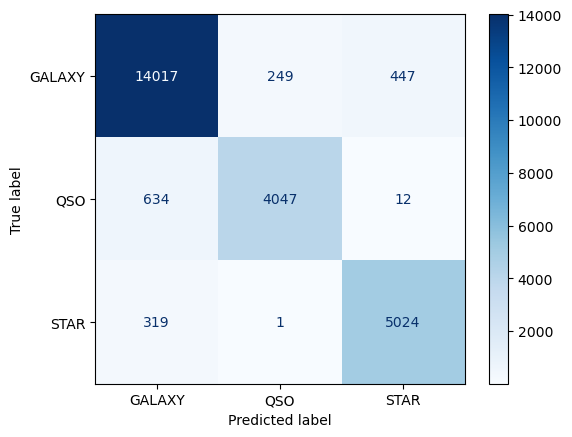

In [50]:
get_results_model(X_train_04, y_train, X_val_04, y_val, MLPClassifier, parameters)

##### 5.3.1.6. Teste com conjunto nº 5

[FOLD 0] SCORE = 0.94907
[FOLD 1] SCORE = 0.9404
[FOLD 2] SCORE = 0.94467
[FOLD 3] SCORE = 0.94747
[FOLD 4] SCORE = 0.94627
[FOLD 5] SCORE = 0.94933
[FOLD 6] SCORE = 0.94307
[FOLD 7] SCORE = 0.93987
[FOLD 8] SCORE = 0.94733
[FOLD 9] SCORE = 0.94466
Acurácia média dos k-folds:.......0.945212595457172
Acurácia no conjunto de treino:... 0.939
Acurácia no conjunto de validação: 0.938
              precision    recall  f1-score   support

      GALAXY       0.95      0.95      0.95     14713
         QSO       0.96      0.87      0.91      4693
        STAR       0.90      0.97      0.93      5344

    accuracy                           0.94     24750
   macro avg       0.93      0.93      0.93     24750
weighted avg       0.94      0.94      0.94     24750



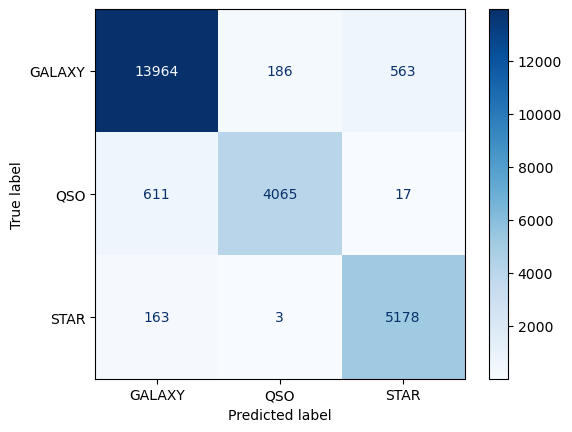

In [45]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, parameters)

##### 5.3.1.7. Teste com conjunto nº 6

[FOLD 0] SCORE = 0.91573
[FOLD 1] SCORE = 0.92067
[FOLD 2] SCORE = 0.92027
[FOLD 3] SCORE = 0.92147
[FOLD 4] SCORE = 0.91813
[FOLD 5] SCORE = 0.92347
[FOLD 6] SCORE = 0.9128
[FOLD 7] SCORE = 0.91773
[FOLD 8] SCORE = 0.92653
[FOLD 9] SCORE = 0.91799
Acurácia média dos k-folds:.......0.9194789065208694
Acurácia no conjunto de treino:... 0.917
Acurácia no conjunto de validação: 0.915
              precision    recall  f1-score   support

      GALAXY       0.93      0.92      0.93     14713
         QSO       0.95      0.79      0.86      4693
        STAR       0.86      1.00      0.92      5344

    accuracy                           0.92     24750
   macro avg       0.91      0.90      0.90     24750
weighted avg       0.92      0.92      0.91     24750



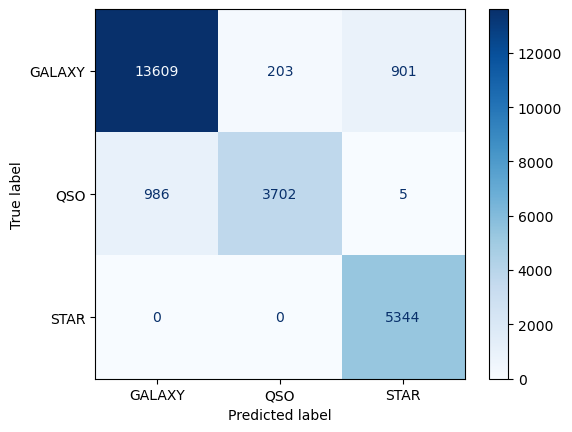

In [55]:
get_results_model(X_train_06, y_train, X_val_06, y_val, MLPClassifier, parameters)

##### 5.3.1.8. Teste com função de ativação tangente hiperbólica

In [60]:
parameters = {
    'activation': 'tanh', 
    'solver': 'sgd', 
    'hidden_layer_sizes': (10, ), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.948
[FOLD 1] SCORE = 0.9416
[FOLD 2] SCORE = 0.94307
[FOLD 3] SCORE = 0.94573
[FOLD 4] SCORE = 0.94347
[FOLD 5] SCORE = 0.94867
[FOLD 6] SCORE = 0.94373
[FOLD 7] SCORE = 0.94053
[FOLD 8] SCORE = 0.94573
[FOLD 9] SCORE = 0.94319
Acurácia média dos k-folds:.......0.9443725758990087
Acurácia no conjunto de treino:... 0.937
Acurácia no conjunto de validação: 0.936
              precision    recall  f1-score   support

      GALAXY       0.95      0.95      0.95     14713
         QSO       0.95      0.87      0.91      4693
        STAR       0.90      0.96      0.93      5344

    accuracy                           0.94     24750
   macro avg       0.93      0.93      0.93     24750
weighted avg       0.94      0.94      0.94     24750



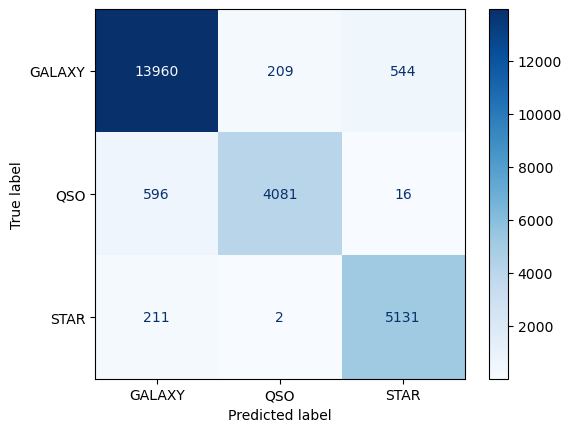

In [61]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, parameters)

##### 5.3.1.9. Teste com função de ativação logística

In [62]:
parameters = {
    'activation': 'logistic', 
    'solver': 'sgd', 
    'hidden_layer_sizes': (10, ), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.7808
[FOLD 1] SCORE = 0.77493
[FOLD 2] SCORE = 0.77867
[FOLD 3] SCORE = 0.77773
[FOLD 4] SCORE = 0.7872
[FOLD 5] SCORE = 0.77947
[FOLD 6] SCORE = 0.77373
[FOLD 7] SCORE = 0.77813
[FOLD 8] SCORE = 0.774
[FOLD 9] SCORE = 0.77344
Acurácia média dos k-folds:.......0.7778103124861093
Acurácia no conjunto de treino:... 0.745
Acurácia no conjunto de validação: 0.745
              precision    recall  f1-score   support

      GALAXY       0.70      0.99      0.82     14713
         QSO       0.95      0.83      0.89      4693
        STAR       0.65      0.01      0.01      5344

    accuracy                           0.75     24750
   macro avg       0.77      0.61      0.57     24750
weighted avg       0.74      0.75      0.66     24750



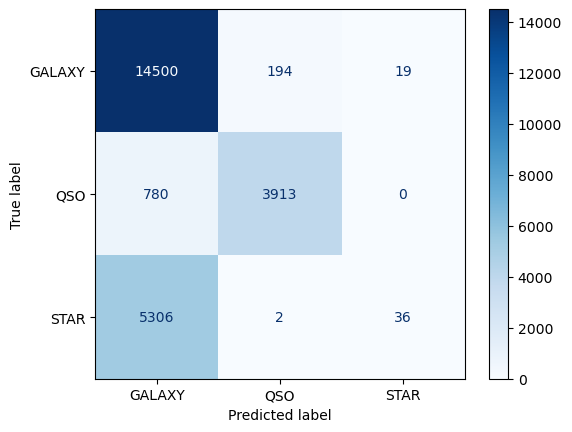

In [63]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, parameters)

##### 5.3.1.10. Teste com função de ativação identidade

In [64]:
parameters = {
    'activation': 'identity', 
    'solver': 'sgd', 
    'hidden_layer_sizes': (10, ), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.94893
[FOLD 1] SCORE = 0.9404
[FOLD 2] SCORE = 0.94253
[FOLD 3] SCORE = 0.9464
[FOLD 4] SCORE = 0.9428
[FOLD 5] SCORE = 0.948
[FOLD 6] SCORE = 0.94387
[FOLD 7] SCORE = 0.94027
[FOLD 8] SCORE = 0.9448
[FOLD 9] SCORE = 0.94239
Acurácia média dos k-folds:.......0.9440392318975863
Acurácia no conjunto de treino:... 0.937
Acurácia no conjunto de validação: 0.937
              precision    recall  f1-score   support

      GALAXY       0.95      0.95      0.95     14713
         QSO       0.95      0.87      0.91      4693
        STAR       0.90      0.96      0.93      5344

    accuracy                           0.94     24750
   macro avg       0.93      0.93      0.93     24750
weighted avg       0.94      0.94      0.94     24750



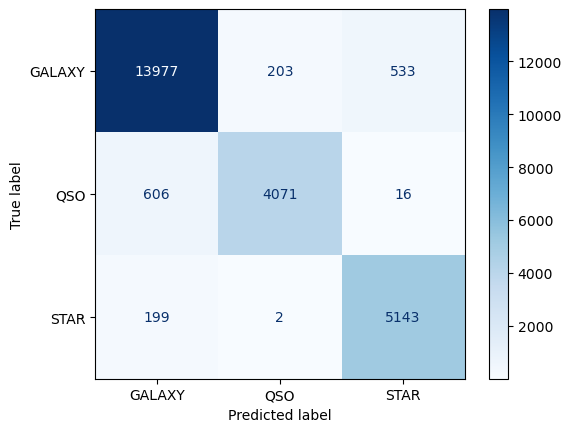

In [65]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, parameters)

##### 5.3.1.11. Teste com solver lbfgs

In [70]:
parameters = {
    'activation': 'relu', 
    'solver': 'lbfgs', 
    'hidden_layer_sizes': (10, ), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.9652
[FOLD 1] SCORE = 0.96027
[FOLD 2] SCORE = 0.96053
[FOLD 3] SCORE = 0.96387
[FOLD 4] SCORE = 0.96813
[FOLD 5] SCORE = 0.966
[FOLD 6] SCORE = 0.96307
[FOLD 7] SCORE = 0.9616
[FOLD 8] SCORE = 0.96227
[FOLD 9] SCORE = 0.9644
Acurácia média dos k-folds:.......0.9635328586033692
Acurácia no conjunto de treino:... 0.963
Acurácia no conjunto de validação: 0.961
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     14713
         QSO       0.95      0.88      0.91      4693
        STAR       0.98      1.00      0.99      5344

    accuracy                           0.96     24750
   macro avg       0.96      0.95      0.95     24750
weighted avg       0.96      0.96      0.96     24750



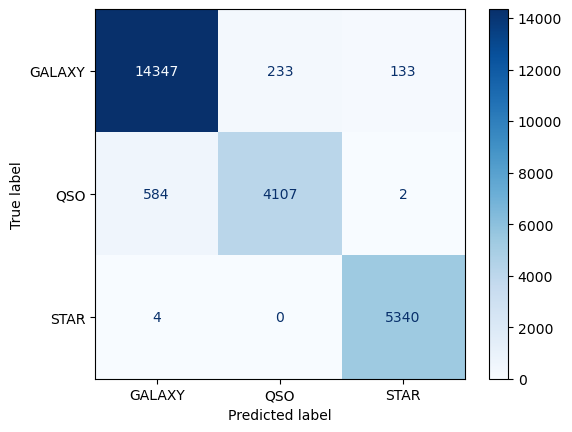

In [71]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, parameters)

##### 5.3.1.12. Teste com solver adam

In [72]:
parameters = {
    'activation': 'relu', 
    'solver': 'adam', 
    'hidden_layer_sizes': (10, ), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.96947
[FOLD 1] SCORE = 0.96507
[FOLD 2] SCORE = 0.966
[FOLD 3] SCORE = 0.96733
[FOLD 4] SCORE = 0.96813
[FOLD 5] SCORE = 0.968
[FOLD 6] SCORE = 0.96693
[FOLD 7] SCORE = 0.9656
[FOLD 8] SCORE = 0.96787
[FOLD 9] SCORE = 0.96466
Acurácia média dos k-folds:.......0.9669061954927324
Acurácia no conjunto de treino:... 0.965
Acurácia no conjunto de validação: 0.965
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     14713
         QSO       0.96      0.90      0.93      4693
        STAR       0.96      1.00      0.98      5344

    accuracy                           0.97     24750
   macro avg       0.96      0.96      0.96     24750
weighted avg       0.97      0.97      0.96     24750



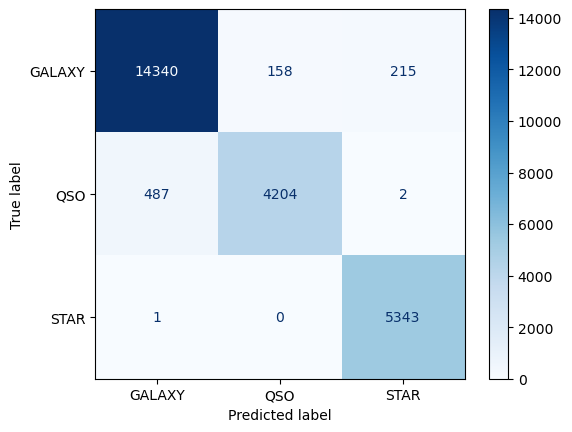

In [73]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, parameters)

##### 5.3.1.13. Teste com camadas (20, )

In [75]:
parameters = {
    'activation': 'relu', 
    'solver': 'adam', 
    'hidden_layer_sizes': (20, ), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.97067
[FOLD 1] SCORE = 0.9676
[FOLD 2] SCORE = 0.96893
[FOLD 3] SCORE = 0.97013
[FOLD 4] SCORE = 0.96853
[FOLD 5] SCORE = 0.97093
[FOLD 6] SCORE = 0.9696
[FOLD 7] SCORE = 0.96867
[FOLD 8] SCORE = 0.9692
[FOLD 9] SCORE = 0.96493
Acurácia média dos k-folds:.......0.9689195323820954
Acurácia no conjunto de treino:... 0.969
Acurácia no conjunto de validação: 0.969
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.97     14713
         QSO       0.95      0.92      0.93      4693
        STAR       0.97      1.00      0.98      5344

    accuracy                           0.97     24750
   macro avg       0.96      0.96      0.96     24750
weighted avg       0.97      0.97      0.97     24750



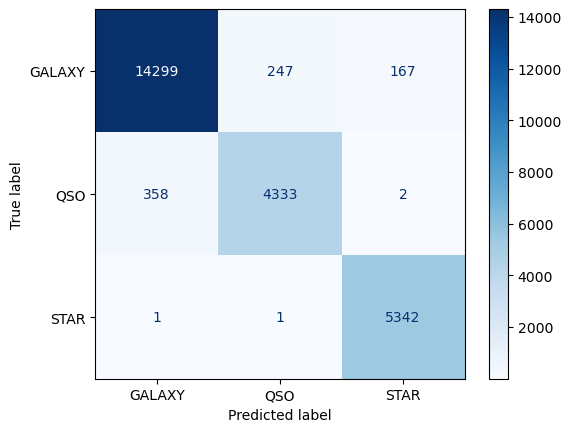

In [76]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, params=parameters)

##### 5.3.1.14. Teste com camadas (25, 10)

In [79]:
parameters = {
    'activation': 'relu', 
    'solver': 'adam', 
    'hidden_layer_sizes': (25, 10), 
    'random_state': seed
}

[FOLD 0] SCORE = 0.97307
[FOLD 1] SCORE = 0.9684
[FOLD 2] SCORE = 0.96987
[FOLD 3] SCORE = 0.96987
[FOLD 4] SCORE = 0.97227
[FOLD 5] SCORE = 0.97213
[FOLD 6] SCORE = 0.96933
[FOLD 7] SCORE = 0.9692
[FOLD 8] SCORE = 0.9696
[FOLD 9] SCORE = 0.96706
Acurácia média dos k-folds:.......0.9700795608303329
Acurácia no conjunto de treino:... 0.971
Acurácia no conjunto de validação: 0.969
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     14713
         QSO       0.96      0.91      0.93      4693
        STAR       0.97      1.00      0.99      5344

    accuracy                           0.97     24750
   macro avg       0.97      0.96      0.96     24750
weighted avg       0.97      0.97      0.97     24750



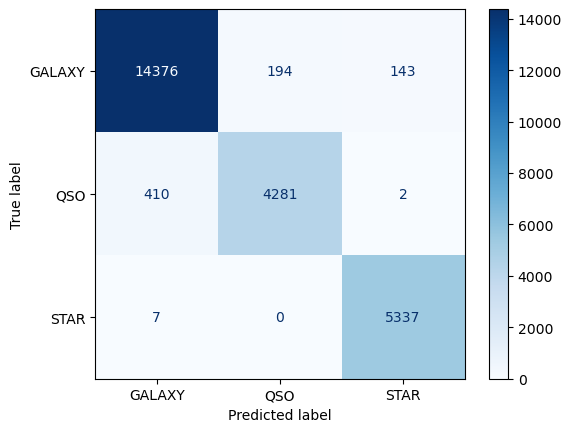

In [80]:
get_results_model(X_train_05, y_train, X_val_05, y_val, MLPClassifier, params=parameters)

#### 5.3.2. Floresta Aleatória

##### 5.3.2.1. Teste com profundidade máxima 10

In [93]:
parameters = {
    'max_depth': 10,
    'criterion': 'gini',
    'n_estimators': 100,
    'random_state': seed
}

[FOLD 0] SCORE = 0.9768
[FOLD 1] SCORE = 0.9728
[FOLD 2] SCORE = 0.97347
[FOLD 3] SCORE = 0.9748
[FOLD 4] SCORE = 0.97613
[FOLD 5] SCORE = 0.97573
[FOLD 6] SCORE = 0.9748
[FOLD 7] SCORE = 0.97267
[FOLD 8] SCORE = 0.9728
[FOLD 9] SCORE = 0.972
Acurácia média dos k-folds:.......0.9741996266168822
Acurácia no conjunto de treino:... 0.980
Acurácia no conjunto de validação: 0.974
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     14713
         QSO       0.97      0.92      0.94      4693
        STAR       0.98      1.00      0.99      5344

    accuracy                           0.97     24750
   macro avg       0.97      0.97      0.97     24750
weighted avg       0.97      0.97      0.97     24750



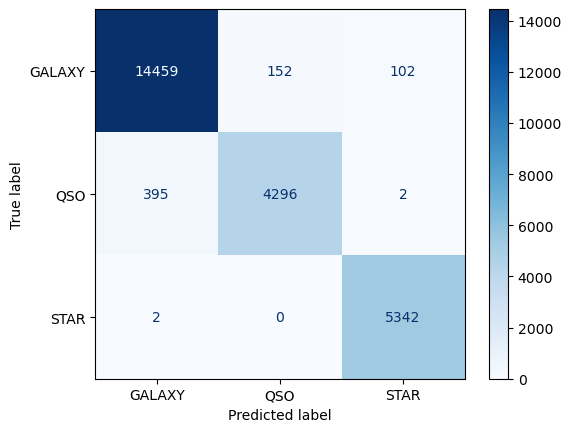

In [94]:
get_results_model(X_train_05, y_train, X_val_05, y_val, RandomForestClassifier, parameters)

##### 5.3.2.2. Testando com profundidade máxima 12

In [95]:
parameters = {
    'max_depth': 12,
    'criterion': 'gini',
    'n_estimators': 100,
    'random_state': seed
}

[FOLD 0] SCORE = 0.97747
[FOLD 1] SCORE = 0.97307
[FOLD 2] SCORE = 0.97373
[FOLD 3] SCORE = 0.9748
[FOLD 4] SCORE = 0.97773
[FOLD 5] SCORE = 0.976
[FOLD 6] SCORE = 0.97587
[FOLD 7] SCORE = 0.97347
[FOLD 8] SCORE = 0.9732
[FOLD 9] SCORE = 0.97333
Acurácia média dos k-folds:.......0.9748663110636974
Acurácia no conjunto de treino:... 0.985
Acurácia no conjunto de validação: 0.974
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     14713
         QSO       0.97      0.92      0.94      4693
        STAR       0.98      1.00      0.99      5344

    accuracy                           0.97     24750
   macro avg       0.97      0.97      0.97     24750
weighted avg       0.97      0.97      0.97     24750



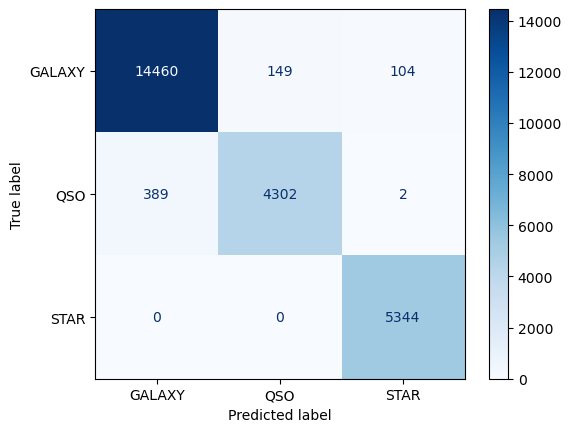

In [96]:
get_results_model(X_train_05, y_train, X_val_05, y_val, RandomForestClassifier, parameters)

##### 5.3.2.3. Testando com n_estimators 10

In [111]:
parameters = {
    'max_depth': 12,
    'criterion': 'gini',
    'n_estimators': 7,
    'random_state': seed
}

[FOLD 0] SCORE = 0.97707
[FOLD 1] SCORE = 0.97013
[FOLD 2] SCORE = 0.97147
[FOLD 3] SCORE = 0.9744
[FOLD 4] SCORE = 0.97667
[FOLD 5] SCORE = 0.9748
[FOLD 6] SCORE = 0.97373
[FOLD 7] SCORE = 0.97293
[FOLD 8] SCORE = 0.97333
[FOLD 9] SCORE = 0.97186
Acurácia média dos k-folds:.......0.9736396248388675
Acurácia no conjunto de treino:... 0.985
Acurácia no conjunto de validação: 0.974
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     14713
         QSO       0.96      0.92      0.94      4693
        STAR       0.98      1.00      0.99      5344

    accuracy                           0.97     24750
   macro avg       0.97      0.97      0.97     24750
weighted avg       0.97      0.97      0.97     24750



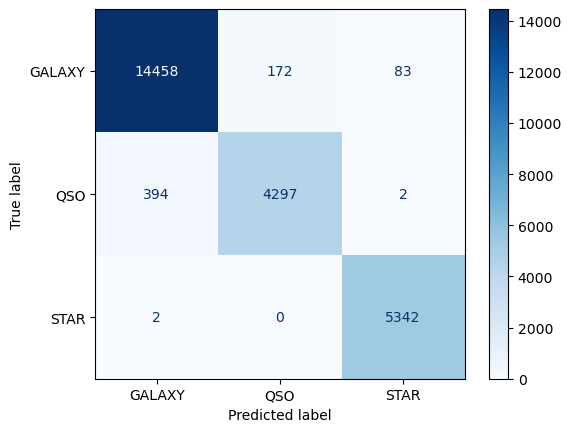

In [112]:
get_results_model(X_train_05, y_train, X_val_05, y_val, RandomForestClassifier, parameters)

##### 5.3.2.4. Testando com critério log_loss

In [113]:
parameters = {
    'max_depth': 12,
    'criterion': 'log_loss',
    'n_estimators': 10,
    'random_state': seed
}

[FOLD 0] SCORE = 0.97587
[FOLD 1] SCORE = 0.97373
[FOLD 2] SCORE = 0.97307
[FOLD 3] SCORE = 0.9736
[FOLD 4] SCORE = 0.97627
[FOLD 5] SCORE = 0.97693
[FOLD 6] SCORE = 0.97493
[FOLD 7] SCORE = 0.9724
[FOLD 8] SCORE = 0.9728
[FOLD 9] SCORE = 0.97306
Acurácia média dos k-folds:.......0.9742663075076676
Acurácia no conjunto de treino:... 0.985
Acurácia no conjunto de validação: 0.973
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     14713
         QSO       0.96      0.92      0.94      4693
        STAR       0.98      1.00      0.99      5344

    accuracy                           0.97     24750
   macro avg       0.97      0.97      0.97     24750
weighted avg       0.97      0.97      0.97     24750



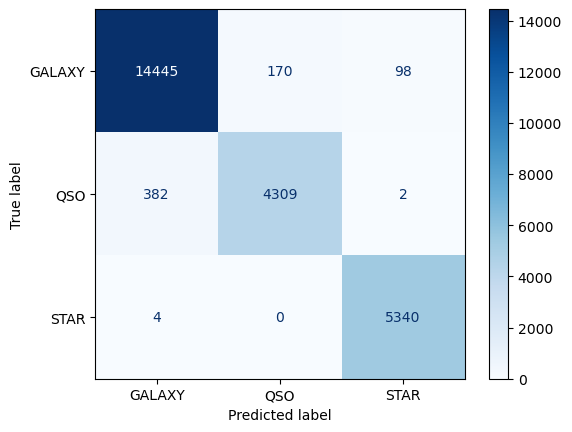

In [114]:
get_results_model(X_train_05, y_train, X_val_05, y_val, RandomForestClassifier, parameters)

##### 5.3.2.5. Testando com critério log_loss

In [115]:
parameters = {
    'max_depth': 12,
    'criterion': 'entropy',
    'n_estimators': 10,
    'random_state': seed
}

[FOLD 0] SCORE = 0.97587
[FOLD 1] SCORE = 0.97373
[FOLD 2] SCORE = 0.97307
[FOLD 3] SCORE = 0.9736
[FOLD 4] SCORE = 0.97627
[FOLD 5] SCORE = 0.97693
[FOLD 6] SCORE = 0.97493
[FOLD 7] SCORE = 0.9724
[FOLD 8] SCORE = 0.9728
[FOLD 9] SCORE = 0.97306
Acurácia média dos k-folds:.......0.9742663075076676
Acurácia no conjunto de treino:... 0.985
Acurácia no conjunto de validação: 0.973
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     14713
         QSO       0.96      0.92      0.94      4693
        STAR       0.98      1.00      0.99      5344

    accuracy                           0.97     24750
   macro avg       0.97      0.97      0.97     24750
weighted avg       0.97      0.97      0.97     24750



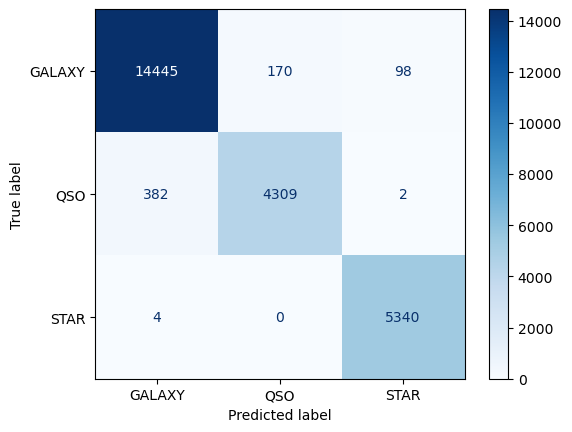

In [116]:
get_results_model(X_train_05, y_train, X_val_05, y_val, RandomForestClassifier, parameters)

### 5.4. Teste Final

#### 5.4.1. Redes Neurais

In [117]:
parameters = {
    'activation': 'relu', 
    'solver': 'adam', 
    'hidden_layer_sizes': (25, 10), 
    'random_state': seed
}

Acurácia no conjunto de treino: 0.970
Acurácia no conjunto de teste:. 0.968
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     14862
         QSO       0.95      0.92      0.93      4740
        STAR       0.97      1.00      0.99      5398

    accuracy                           0.97     25000
   macro avg       0.96      0.96      0.96     25000
weighted avg       0.97      0.97      0.97     25000



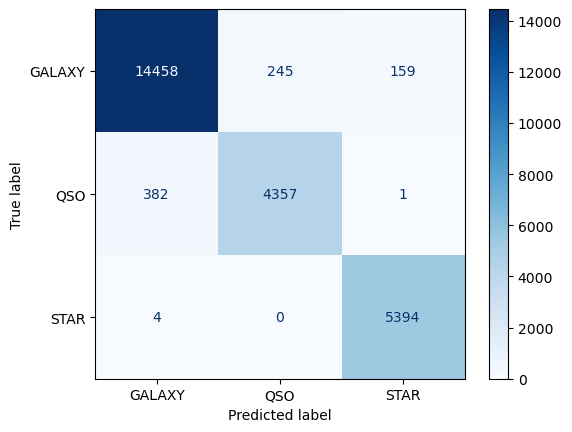

In [119]:
cls = MLPClassifier(**parameters)

cls.fit(X_training_05, y_training)

y_pred = cls.predict(X_test_05.values)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=cls.classes_
)

print("Acurácia no conjunto de treino: {:.3f}".format(cls.score(X_training_05.values, y_training.values)))
print("Acurácia no conjunto de teste:. {:.3f}".format(cls.score(X_test_05.values, y_test.values)))
print(classification_report(y_test.values, y_pred))

disp.plot(cmap='Blues')

plt.show()

#### 5.4.2. Floresta Aleatória

In [85]:
parameters = {
    'max_depth': 12,
    'criterion': 'gini',
    'n_estimators': 10,
    'random_state': seed
}

Acurácia no conjunto de treino: 0.984
Acurácia no conjunto de teste:. 0.973
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     14862
         QSO       0.95      0.93      0.94      4740
        STAR       0.98      1.00      0.99      5398

    accuracy                           0.97     25000
   macro avg       0.97      0.97      0.97     25000
weighted avg       0.97      0.97      0.97     25000



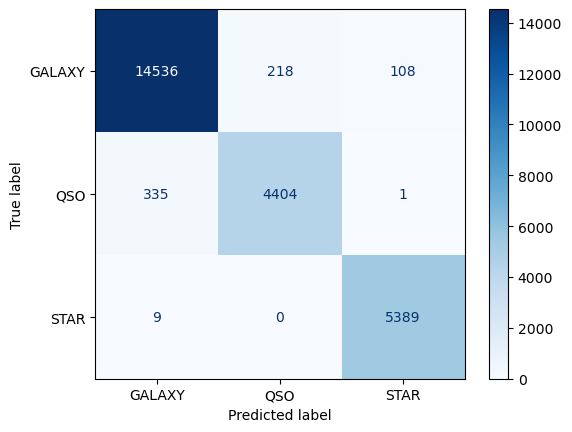

In [121]:
cls = RandomForestClassifier(**parameters)

cls.fit(X_training_05, y_training)

y_pred = cls.predict(X_test_05.values)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=cls.classes_
)

print("Acurácia no conjunto de treino: {:.3f}".format(cls.score(X_training_05.values, y_training.values)))
print("Acurácia no conjunto de teste:. {:.3f}".format(cls.score(X_test_05.values, y_test.values)))
print(classification_report(y_test.values, y_pred))

disp.plot(cmap='Blues')

plt.show()